In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [135]:
training_data = pd.read_csv('./data/cs-training.csv', index_col='Unnamed: 0')
test_data = pd.read_csv('./data/cs-test.csv', index_col='Unnamed: 0')
sample_entry = pd.read_csv('./data/sampleEntry.csv')

In [136]:
training_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [137]:
training_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Removes Rows with Missing Monthly Income and Missing Dependents:

In [165]:
training_data = training_data[training_data['MonthlyIncome'].isna() == False]
training_data = training_data[training_data['age'] >= 20]
# print('New Data Set Length (Number of Rows:)', len(training_data))
# print('Also, this effectively removes any rows with missing dependents.')

## First two Features - Number of Dependents & Age as Decades:


In [166]:
# Noted features that need transformation, for later
# RevolvingUtilizationOfUnsecuredLines
# NumberOfTime30-59DaysPastDueNotWorse
# DebtRatio
# NumberOfOpenCreditLinesAndLoans
# NumberOfTimes90DaysLate
# NumberRealEstateLoansOrLines
# NumberOfTime60-89DaysPastDueNotWorse

training_data = training_data[training_data['NumberOfDependents'] <= 4]

In [172]:
# Additional plots, saved for later
# sns.kdeplot(data=training_data, x='age', hue='SeriousDlqin2yrs', common_norm=False)
# sns.histplot(data=training_data, x='age', hue='SeriousDlqin2yrs', bins=30, stat='density', common_norm=False)

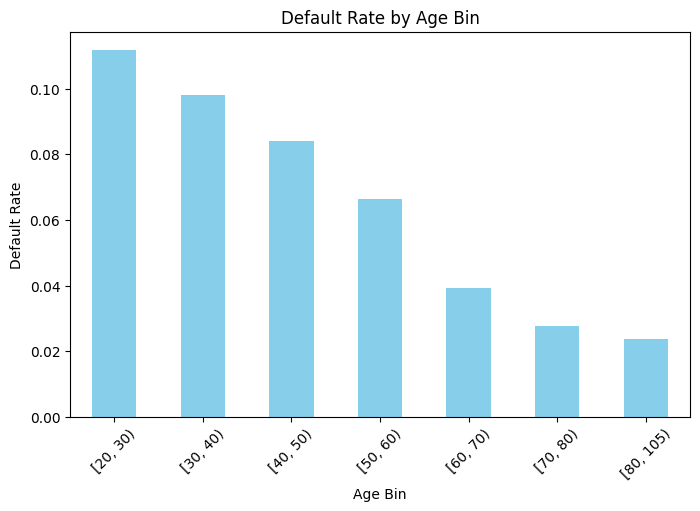

In [174]:
training_data['age_bin'] = pd.cut(training_data['age'], bins=[20,30,40,50,60,70,80,105], right=False)
rate_per_bin = training_data.groupby('age_bin', observed=True)['SeriousDlqin2yrs'].mean()

plt.figure(figsize=(8,5))
rate_per_bin.plot(kind='bar', color='skyblue')
plt.xlabel('Age Bin')
plt.ylabel('Default Rate')
plt.title('Default Rate by Age Bin')
plt.xticks(rotation=45)
plt.show()

### The trend shows a consistent, near linear decrease of defaults with age.  
### I will use a midpoint for each age decade to train the model:

In [175]:
training_data['age_bin_mid'] = training_data['age_bin'].apply(lambda x: (x.left + x.right)/2)

In [176]:
training_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_bin,age_bin_mid
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,"[40, 50)",45.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,"[40, 50)",45.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,"[30, 40)",35.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,"[30, 40)",35.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,"[40, 50)",45.0


In [177]:
X = training_data[['age_bin_mid']]
Y = training_data['SeriousDlqin2yrs']
# print(training_data['age_bin_mid'].isna().sum())      for debugging
# mask = X['age_bin_mid'].notna()

In [178]:
Y.head()

1    1
2    0
3    0
4    0
5    0
Name: SeriousDlqin2yrs, dtype: int64

In [180]:
from sklearn.linear_model import LogisticRegression

#initialize the model
model = LogisticRegression(C=1e6)

# fit the model
model.fit(X, Y)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1000000.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter